# Artificial Intelligence Final Project
### Machine Translation ( English -> German )

##### Team
- Dikshant Sagar
- Nimesh Arora
- Shreyas Teli
- Safal Rijal
- Ashish Gujrang

In [1]:
import os
import collections
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GRU, LSTM, Input, Dense, TimeDistributed, Activation, Dropout, Embedding, Bidirectional, RepeatVector, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

from nltk.translate.bleu_score import sentence_bleu
from nltk.util import ngrams
import pandas as pd
import string
import matplotlib.pyplot as plt
plt.style.use('seaborn')

import seaborn as sns


<ipython-input-1-2dc6799411ef>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

In [3]:

# Load English data
english_sentences = load_data('small_vocab_en')
# Load german data
german_sentences = load_data('small_vocab_de')

print('Dataset Loaded')

for sample_i in range(2):
    print('small_vocab_en Line {}:  {}'.format(sample_i + 1, english_sentences[sample_i]))
    print('small_vocab_de Line {}:  {}'.format(sample_i + 1, german_sentences[sample_i]))

Dataset Loaded
small_vocab_en Line 1:  new jersey is sometimes quiet during autumn , and it is snowy in april .
small_vocab_de Line 1:  Neues Trikot ist manchmal ruhig im Herbst, und es ist im April verschneit.
small_vocab_en Line 2:  the united states is usually chilly during july , and it is usually freezing in november .
small_vocab_de Line 2:  Die Vereinigten Staaten ist in der Regel kühl während Juli, und es ist in der Regel im November frieren.



# Creating Vocabulary
 
 Here we are creating vocabulary dictionaries from the English and German Corpora

In [4]:
english_words_counter = collections.Counter([word for sentence in english_sentences for word in sentence.split()])
german_words_counter = collections.Counter([word for sentence in german_sentences for word in sentence.split()])

print('{} Language 1 words.'.format(len([word for sentence in english_sentences for word in sentence.split()])))
print('{} unique Language 1 words.'.format(len(english_words_counter)))
print('10 Most common words in the Language 1 dataset:')
print('"' + '" "'.join(list(zip(*english_words_counter.most_common(10)))[0]) + '"')
print()
print('{} Language 2 words.'.format(len([word for sentence in german_sentences for word in sentence.split()])))
print('{} unique Language 2 words.'.format(len(german_words_counter)))
print('10 Most common words in the Language 2 dataset:')
print('"' + '" "'.join(list(zip(*german_words_counter.most_common(10)))[0]) + '"')

1823250 Language 1 words.
227 unique Language 1 words.
10 Most common words in the Language 1 dataset:
"is" "," "." "in" "it" "during" "the" "but" "and" "sometimes"

1668544 Language 2 words.
704 unique Language 2 words.
10 Most common words in the Language 2 dataset:
"ist" "im" "es" "aber" "und" "die" "der" "während" "am" "in"


# Preprocess

For this project, we'll convert the text into sequences of integers using the following preprocess methods:
1. Tokenize the words into ids
2. Add padding to make all the sequences the same length.


### Tokenize


In [5]:

def tokenize(x):
    """
    Tokenize x
    :param x: List of sentences/strings to be tokenized
    :return: Tuple of (tokenized x data, tokenizer used to tokenize x)
    """
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(x)
    return tokenizer.texts_to_sequences(x), tokenizer
  

### Pad


In [6]:
def pad(x, length=None):
    """
    Pad x
    :param x: List of sequences.
    :param length: Length to pad the sequence to.  If None, use length of longest sequence in x.
    :return: Padded numpy array of sequences
    """
    return pad_sequences(x, maxlen=length, padding='post')


### Total Preprocess Pipeline


In [7]:
def preprocess(x, y):
    """
    Preprocess x and y
    :param x: Feature List of sentences
    :param y: Label List of sentences
    :return: Tuple of (Preprocessed x, Preprocessed y, x tokenizer, y tokenizer)
    """
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

preproc_english_sentences, preproc_german_sentences, english_tokenizer, german_tokenizer =\
    preprocess(english_sentences, german_sentences)

print('Data Preprocessed')

Data Preprocessed



### Ids Back to Text
The neural network will be translating the input to words ids, which isn't the final form we want.  We want the german translation.  The function `logits_to_text` will bridge the gab between the logits from the neural network to the german translation.  You'll be using this function to better understand the output of the neural network.

In [8]:
def logits_to_text(logits, tokenizer):
    """
    Turn logits from a neural network into text using the tokenizer
    :param logits: Logits from a neural network
    :param tokenizer: Keras Tokenizer fit on the labels
    :return: String that represents the text of the logits
    """
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])


In [9]:
metrics = {}

In [10]:
def calculate_metrics(candidate, reference, n):
    candidate_ngrams = list(ngrams(candidate, n))
    reference_ngrams = list(ngrams(reference, n))
    
    intersection_count = len(set(candidate_ngrams) & set(reference_ngrams))
    reference_count = len(reference_ngrams)
    
    precision = intersection_count / len(candidate_ngrams)
    recall = intersection_count / reference_count
    
    if precision + recall > 0:
        f1_score = (2 * precision * recall) / (precision + recall)
    else:
        f1_score = 0.0
    
    return precision, recall, f1_score

In [11]:
def get_metrics(pred):
  
  btemp = []
  for i in range(len(pred)):
    tr = logits_to_text(pred[i], german_tokenizer).replace('<PAD>', '')
    ref = german_sentences[i].lower()
    btemp.append(calculate_metrics(ref.split(), tr.split(), n=2))

  return np.mean(np.array(btemp), axis=0)


## Models

Here we define and train different models using layers that are used in NLP Applications like : GRU, LSTM, Embedding, Bidirectional Layers, etc.



### Model 1: Simple RNN/GRU Model


In [12]:



def rnn_model(input_shape, output_sequence_length, english_vocab_size, german_vocab_size):
    """
    Build and train a basic RNN on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param german_vocab_size: Number of unique german words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Build the layers
    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(GRU(256, input_shape=input_shape[1:], return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(german_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


# Reshaping the input to work with a basic RNN
tmp_x = pad(preproc_english_sentences, preproc_german_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_german_sentences.shape[-2], 1))

# Train the neural network
simple_rnn_model = rnn_model(
    tmp_x.shape,
    preproc_german_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(german_tokenizer.word_index)+1)

print(simple_rnn_model.summary())
rnn_history = simple_rnn_model.fit(tmp_x, preproc_german_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# Print prediction(s)
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], german_tokenizer))
metrics['Simple RNN'] = get_metrics(simple_rnn_model.predict(tmp_x[:10]))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 256)           198912    
                                                                 
 time_distributed (TimeDistr  (None, 20, 1024)         263168    
 ibuted)                                                         
                                                                 
 dropout (Dropout)           (None, 20, 1024)          0         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 382)          391550    
 tributed)                                                       
                                                                 
Total params: 853,630
Trainable params: 853,630
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
108/108 [=========================

### Model 2: Simple RNN Model Using Embedding Layer



In [13]:

def rnn_embed_model(input_shape, output_sequence_length, english_vocab_size, german_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param german_vocab_size: Number of unique german words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(GRU(256, return_sequences=True))    
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(german_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model




# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_german_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_german_sentences.shape[-2]))

# TODO: Train the neural network
embed_rnn_model = rnn_embed_model(
    tmp_x.shape,
    preproc_german_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(german_tokenizer.word_index)+1)

print(embed_rnn_model.summary())

embed_rnn_history = embed_rnn_model.fit(tmp_x, preproc_german_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# TODO: Print prediction(s)
print(logits_to_text(embed_rnn_model.predict(tmp_x[:1])[0], german_tokenizer))
metrics['Simple RNN With Embedding'] = get_metrics(embed_rnn_model.predict(tmp_x[:10]))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 256)           51200     
                                                                 
 gru_1 (GRU)                 (None, 20, 256)           394752    
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_1 (Dropout)         (None, 20, 1024)          0         
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 382)          391550    
 tributed)                                                       
                                                                 
Total params: 1,100,670
Trainable params: 1,100,670
No

### Model 3: LSTM Model Using Embedding Layer



In [14]:

def lstm_embed_model(input_shape, output_sequence_length, english_vocab_size, german_vocab_size):
    """
    Build and train a RNN model using word embedding on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param german_vocab_size: Number of unique german words in the dataset
    :return: Keras model built, but not trained
    """
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.005
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(LSTM(256, return_sequences=True))    
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(german_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model




# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_german_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_german_sentences.shape[-2]))

# TODO: Train the neural network
lstm_model = lstm_embed_model(
    tmp_x.shape,
    preproc_german_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(german_tokenizer.word_index)+1)

print(lstm_model.summary())

lstm_history = lstm_model.fit(tmp_x, preproc_german_sentences, batch_size=1024, epochs=10, validation_split=0.2)

# TODO: Print prediction(s)
print(logits_to_text(lstm_model.predict(tmp_x[:1])[0], german_tokenizer))
metrics['LSTM with Embeddings'] = get_metrics(lstm_model.predict(tmp_x[:10]))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 256)           51200     
                                                                 
 lstm (LSTM)                 (None, 20, 256)           525312    
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_2 (Dropout)         (None, 20, 1024)          0         
                                                                 
 time_distributed_5 (TimeDis  (None, 20, 382)          391550    
 tributed)                                                       
                                                                 
Total params: 1,231,230
Trainable params: 1,231,230
No

### Model 4: Bidirectional LSTMs


In [15]:



def bi_lstm_model(input_shape, output_sequence_length, english_vocab_size, german_vocab_size):
    """
    Build and train a bidirectional LSTM model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param german_vocab_size: Number of unique german words in the dataset
    :return: Keras model built, but not trained
    """
   
    # TODO: Implement

    # Hyperparameters
    learning_rate = 0.003
    
    # TODO: Build the layers
    model = Sequential()
    model.add(Embedding(english_vocab_size, 256, input_length=input_shape[1], input_shape=input_shape[1:]))
    model.add(Bidirectional(LSTM(256, return_sequences=True),input_shape=(input_shape[1],256)))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(german_vocab_size, activation='softmax'))) 

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    return model


# TODO: Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_german_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_german_sentences.shape[-2]))

# TODO: Train and Print prediction(s)

bidirectional_lstm_model = bi_lstm_model(
    tmp_x.shape,
    preproc_german_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(german_tokenizer.word_index)+1)

bidirectional_lstm_model.summary()

bi_lstm_history = bidirectional_lstm_model.fit(tmp_x, preproc_german_sentences, batch_size=1024, epochs=10, validation_split=0.2)

print(logits_to_text(bidirectional_lstm_model.predict(tmp_x[:1])[0], german_tokenizer))
metrics['Bidirectional LSTM'] = get_metrics(bidirectional_lstm_model.predict(tmp_x[:10]))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 20, 256)           51200     
                                                                 
 bidirectional (Bidirectiona  (None, 20, 512)          1050624   
 l)                                                              
                                                                 
 time_distributed_6 (TimeDis  (None, 20, 1024)         525312    
 tributed)                                                       
                                                                 
 dropout_3 (Dropout)         (None, 20, 1024)          0         
                                                                 
 time_distributed_7 (TimeDis  (None, 20, 382)          391550    
 tributed)                                                       
                                                      

### Model 5: Encoder-Decoder Model


In [16]:

def encdec_model(input_shape, output_sequence_length, english_vocab_size, german_vocab_size):
    """
    Build and train an encoder-decoder model on x and y
    :param input_shape: Tuple of input shape
    :param output_sequence_length: Length of output sequence
    :param english_vocab_size: Number of unique English words in the dataset
    :param german_vocab_size: Number of unique german words in the dataset
    :return: Keras model built, but not trained
    """
    # OPTIONAL: Implement
    
    # Hyperparameters
    learning_rate = 0.001
    
    # Build the layers    
    model = Sequential()
    # Encoder
    model.add(GRU(256, input_shape=input_shape[1:], go_backwards=True))
    model.add(RepeatVector(output_sequence_length))
    # Decoder
    model.add(GRU(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1024, activation='relu')))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(german_vocab_size, activation='softmax')))

    # Compile model
    model.compile(loss=sparse_categorical_crossentropy,
                  optimizer=Adam(learning_rate),
                  metrics=['accuracy'])
    
    return model



# Reshape the input
tmp_x = pad(preproc_english_sentences, preproc_german_sentences.shape[1])
tmp_x = tmp_x.reshape((-1, preproc_german_sentences.shape[-2], 1))

# Train and Print prediction(s)
encdec_rnn_model = encdec_model(
    tmp_x.shape,
    preproc_german_sentences.shape[1],
    len(english_tokenizer.word_index)+1,
    len(german_tokenizer.word_index)+1)

encdec_rnn_model.summary()

encdec_history = encdec_rnn_model.fit(tmp_x, preproc_german_sentences, batch_size=1024, epochs=10, validation_split=0.2)
metrics['Encoder Decoder Model'] = get_metrics(encdec_rnn_model.predict(tmp_x[:10]))

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 256)               198912    
                                                                 
 repeat_vector (RepeatVector  (None, 20, 256)          0         
 )                                                               
                                                                 
 gru_3 (GRU)                 (None, 20, 256)           394752    
                                                                 
 time_distributed_8 (TimeDis  (None, 20, 1024)         263168    
 tributed)                                                       
                                                                 
 dropout_4 (Dropout)         (None, 20, 1024)          0         
                                                                 
 time_distributed_9 (TimeDis  (None, 20, 382)         

1/1 [==============================] - 1s 565ms/step


## Performance And Metrics

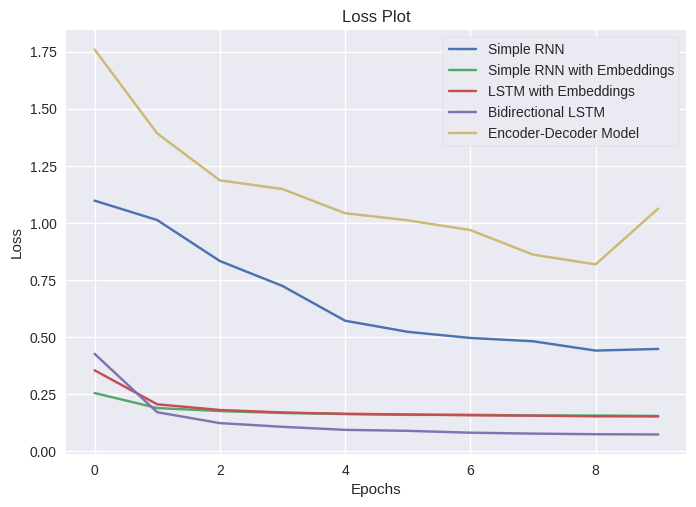

In [17]:
plt.plot(rnn_history.history['val_loss'], label='Simple RNN')
plt.plot(embed_rnn_history.history['val_loss'], label='Simple RNN with Embeddings')
plt.plot(lstm_history.history['val_loss'], label='LSTM with Embeddings')
plt.plot(bi_lstm_history.history['val_loss'], label='Bidirectional LSTM')
plt.plot(encdec_history.history['val_loss'], label='Encoder-Decoder Model')
plt.title("Loss Plot")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=True)
plt.show()

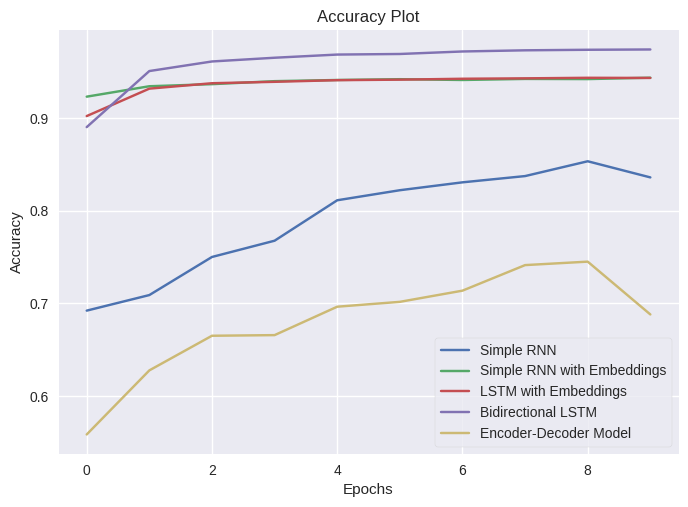

In [18]:
plt.plot(rnn_history.history['val_accuracy'], label='Simple RNN')
plt.plot(embed_rnn_history.history['val_accuracy'], label='Simple RNN with Embeddings')
plt.plot(lstm_history.history['val_accuracy'], label='LSTM with Embeddings')
plt.plot(bi_lstm_history.history['val_accuracy'], label='Bidirectional LSTM')
plt.plot(encdec_history.history['val_accuracy'], label='Encoder-Decoder Model')
plt.title("Accuracy Plot")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=True)
plt.show()

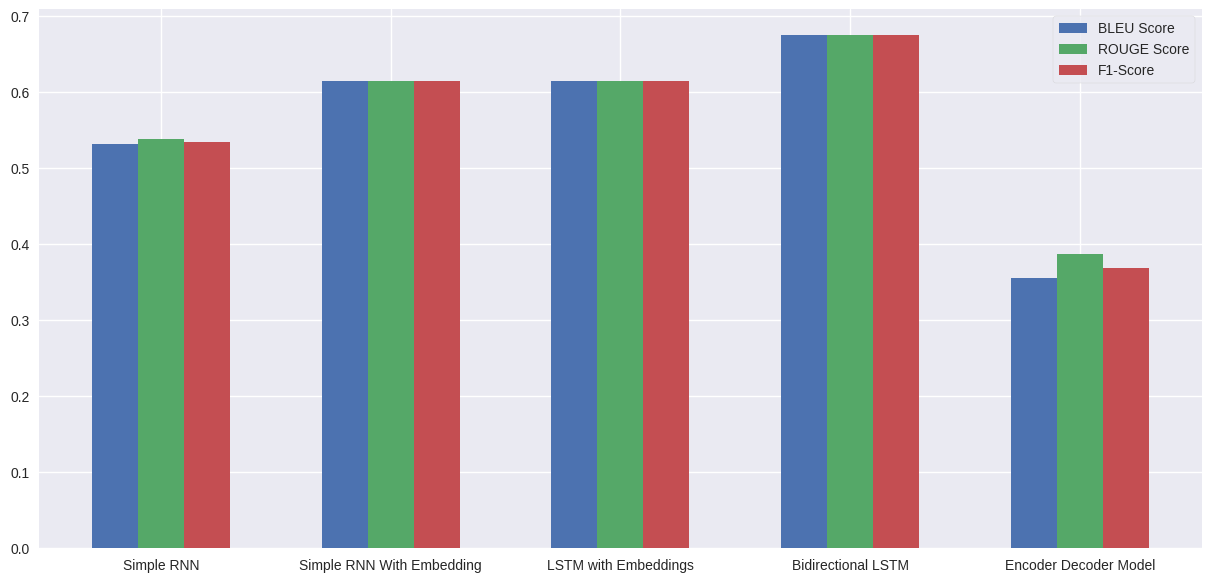

In [19]:
met = pd.DataFrame(metrics).T
met.columns = ["Precision", "Recall", "F1-Score"]
met = met.reset_index()

plt.figure(figsize=(15,7))
xtk = np.arange(5)
plt.bar(xtk-0.2, met['Precision'],width=0.2, label='BLEU Score')
plt.bar(xtk, met['Recall'], width=0.2, label='ROUGE Score')
plt.bar(xtk+0.2, met['F1-Score'],width=0.2, label='F1-Score')

plt.xticks(xtk, met['index'])
plt.legend(frameon=True)

# Save Final Model

In [20]:
bidirectional_lstm_model.save("english_to_german")
